### Case Study: Credit Underwriting and Analysis

A credit company acquires applicants for credit. These applicants apply for credit, and the company decides whether to issue credit.

Using historical data, the business wants to build model that can predict whether an applicant will default, and understand which applicant characteristics drive loan performance.

### Goals:

* Build a predictive classifier. Defaults are both rare and expensive, we prefer a model that has a high recall on the default class.
* Be able to explain why an applicant was approved or denied, in the event that they ask for clarification.
* Uncover which types of applicants the firm should market to.

### Load the data
We are going to perform our analysis on data from LendingClub. Data is available here:

https://www.lendingclub.com/info/download-data.action



In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import pandas as pd
import numpy as np

df = pd.read_csv('LoanStats3a.csv', skiprows=1)
df = df[df.loan_status.isin(['Fully Paid','Charged Off'])]

#remove columns that are entirely null
for column in df.columns:
    if df[column].isnull().mean() >= .99:
        df = df.drop(column, 1)
        
        
#remove columns with constant values
for column in df.columns:
    if df[column].unique().shape[0] == 1:
        df = df.drop(column, 1)        

In [2]:
print("The data has {0} rows and {1} fields".format(*df.shape))

The data has 39786 rows and 45 fields


In [3]:
df.head().T

,0,1,2,3,4
loan_amnt,5000,2500,2400,10000,3000
funded_amnt,5000,2500,2400,10000,3000
funded_amnt_inv,4975,2500,2400,10000,3000
term,36 months,60 months,36 months,36 months,60 months
int_rate,10.65%,15.27%,15.96%,13.49%,12.69%
installment,162.87,59.83,84.33,339.31,67.79
grade,B,C,C,C,B
sub_grade,B2,C4,C5,C1,B5
emp_title,NaN,Ryder,NaN,AIR RESOURCES BOARD,University Medical Group
emp_length,10+ years,< 1 year,10+ years,10+ years,1 year


We want to model loan performance **before** a loan is originated; therefore we should be careful to exclude any information that becomes available **after** the issued, such as recoveries, principle paid, etc.

### Utilities

We are going to define some helper functions for data exploration and model validation.

In [153]:
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve, precision_recall_fscore_support
from sklearn.preprocessing import label_binarize


def def_rates_by_categorical(column, 
                             with_variance=False, 
                             sort=True):
    """"""
    grouped = df.groupby([column,'loan_status'])
    def_counts = grouped['loan_amnt'].count().unstack()
    N = def_counts.sum(axis=1)
    props = def_counts['Charged Off'] / N
    if sort:
        props = props.sort_values()
    var = ((props * (1 - props)) / N) ** (.5)
    if with_variance:
        ax = props.plot(kind = 'bar', yerr = var)
    else:
        ax = props.plot(kind = 'bar')
    ax.set_ylabel("Default Rate (0-1)")
    ax.set_title("Default Rates by {}".format(column))
    ax.set_xlabel(column)
    return ax
    
def round_to_nearest(x, base=1):
    return base * int(x / base)

def plot_roc_curve(y_test, X_test, model_dict):
    y_test_ = label_binarize(y_test, classes=[0, 1, 2])[:, :2]
    preds = {}
    fpr = {}
    tpr = {}
    roc_auc = {}
    f, ax = plt.subplots(1)
    
    #plt.figure()
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic')
    ax.legend(loc="lower right")
    
    plot_data = {}
    
    for model_key in model_dict:
        preds = model_dict[model_key].predict_proba(X_test)
        fpr = {}
        tpr = {} 
        roc_auc = {}        
        
        for i in range(2):
            fpr[i], tpr[i], _ = roc_curve(y_test_[:, i], preds[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test_.ravel(), preds.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
        name = "%s: (AUC = %0.2f)" % (model_key, roc_auc[1])
        plot_data = pd.DataFrame(tpr[1], index=fpr[1], columns = [name])
        plot_data.plot(ax=ax)
    plt.show()
    return ax


def classifaction_report_csv(report):
    report_data = []
    lines = report.split('\n')
    for line in lines[2:-3]:
        row = {}
        row_data = re.split('[ ]+', line)
        row['class'] = row_data[1]
        row['precision'] = float(row_data[2])
        row['recall'] = float(row_data[3])
        row['f1_score'] = float(row_data[4])
        row['support'] = float(row_data[5])
        report_data.append(row)
    dataframe = pd.DataFrame.from_dict(report_data)
    return dataframe

def hover(hover_color="#ffff99"):
    return dict(selector="tr:hover",
                props=[("background-color", "%s" % hover_color)])

styles = [
    hover(),
    dict(selector="th", props=[("font-size", "100%"),
                               ("text-align", "center")]),
    dict(selector="caption", props=[("caption-side", "bottom")])
]

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    

def plot_discriminative_thresholds(model, y_true, include_f1=True):
    probabilities = model.predict_proba(X_test)
    prec = {}
    rec = {}
    f1_scores = {}
    for i in map(lambda x: x / 20., range(20)):
        predictions = np.apply_along_axis(lambda x: x[1] > i, 1, probabilities)
        precision, recall, f1, support = precision_recall_fscore_support(y_test, predictions)
        prec[i] = precision[1]
        rec[i] = recall[1]
        f1_scores[i] = f1[1]
        
    best_i = pd.Series(f1_scores).idxmax()


    default_thresholds = pd.DataFrame({'recall':pd.Series(rec), 
                                       'precision':pd.Series(prec),
                                       'f1':pd.Series(f1_scores)})
    if include_f1:
        ax = default_thresholds.plot()
    else:
        ax = default_thresholds[['recall','precision']].plot()
    ax.axvline(best_i, linestyle= "--", color = 'gray')
    ax.text(1.1, .6, "F1 Optimal Threshold: %.2f" % best_i)
    ax.text(1.1, .52, "Optimal Recall: %.2f" % rec[best_i])
    ax.text(1.1, .44, "Optimal Precision: %.2f" % prec[best_i])
    ax.set_xlabel('Discriminative Threshold')
    return ax

### Preprocessing

In [5]:
re_not_decimal = re.compile(r'[^\.0-9]*')

def process_int_rate(x):
    x = x.strip()
    x = re_not_decimal.sub("", x)    
    return float(x)

def process_revol_util(x):
    if pd.isnull(x):
        return 0
    else:
        x = x.strip()
        x = re_not_decimal.sub("", x)    
        return float(x)

def process_term(x):
    x = re_not_decimal.sub("", x)
    return int(x)

def process_emp_length(x):
    x = re_not_decimal.sub("", x)
    if x == '':
        return np.nan
    else:
        return float(x)
    


df['int_rate'] = df['int_rate'].apply(process_int_rate)
df['term'] = df['term'].apply(process_term)
df['emp_length'] = df['emp_length'].apply(process_emp_length)
df['revol_util'] = df['revol_util'].apply(process_revol_util)
df['pub_rec_bankruptcies'] = df['pub_rec_bankruptcies'].fillna(0)

### Distribution of credit outcomes

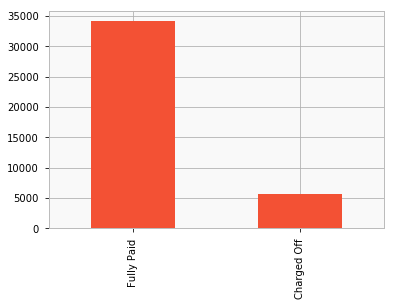

In [6]:
%matplotlib inline
df.loan_status.value_counts().plot(kind='bar')

### Lower grade credit related to default rates

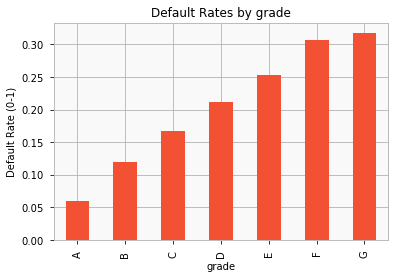

In [7]:
def_rates_by_categorical('grade')

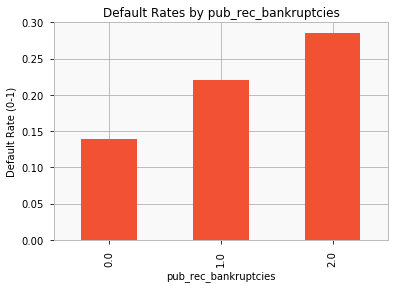

In [8]:
ax = def_rates_by_categorical('pub_rec_bankruptcies')

### DTI also a factor

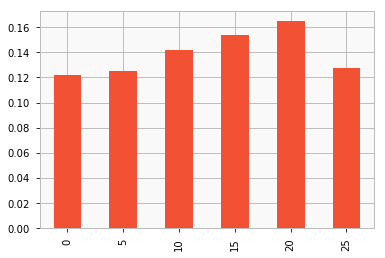

In [9]:
def_by_dti = df.set_index('dti').groupby(by=(lambda x: round_to_nearest(x, 5), 'loan_status'))['loan_amnt'].count().unstack()
def_by_dti = (def_by_dti['Charged Off'] / def_by_dti.sum(axis=1))
ax = def_by_dti.plot(kind = 'bar')

### Not what we'd expect from verification status

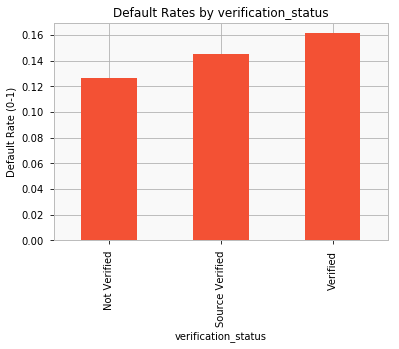

In [10]:
ax = def_rates_by_categorical('verification_status')

### Small business loans are much riskier

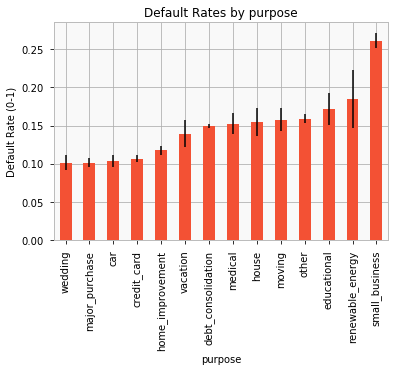

In [11]:
def_rates_by_categorical('purpose', with_variance=True)

### (Light) Feature Engineering

In [12]:
df_ = df.copy()

domain_columns = ['loan_amnt', 
                  'term', 
                  'annual_inc', 
                  'installment_over_income', 
                  'has_employer_info',
                  'is_employed',
                  'dti',
                  'purpose_is_small_business',
                  'inq_last_6mths',
                  'delinq_2yrs',
                  'open_acc',
                  'int_rate',
                  'revol_util',
                  'pub_rec_bankruptcies',
                  'revol_bal',
                  'requested_minus_funded',
                  'debt_to_income'
                 ]

#features to engineer
df_['requested_minus_funded'] = df_['loan_amnt'] - df_['funded_amnt']
df_['has_employer_info'] = df_['emp_title'].isnull()
df_['installment_over_income'] = df_['installment'] / df_['annual_inc']
df_['is_employed'] = df_['emp_length'].isnull()
df_['debt_to_income'] = (df_['revol_bal'] + df_['funded_amnt']) / df['annual_inc']



#dummy section
dummy_columns = ['home_ownership','purpose', 'grade', 'addr_state']

for column in dummy_columns:
    dummies = pd.get_dummies(df_[column], prefix="{}_is".format(column))
    columns_to_add = dummies.columns.values[:-1]
    dummies = dummies[columns_to_add]
    df_ = df_.join(dummies)
    domain_columns.extend(columns_to_add)

df_['default'] = df_['loan_status'].apply(lambda x: 1 if x == 'Charged Off' else 0)

### Train/Test Split

In [13]:
from sklearn.model_selection import train_test_split

X = df_[domain_columns].values
y = df_['default'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .33)

### Train a Logistic Regression

We'll first try out a logistic regression. If the model is performant, explaining its behavior for a given decision, and describing broader relationships between applicant characteristics and default risk is trivial; we can exactly express the model with a few coefficients.

In [87]:
from sklearn.linear_model import LogisticRegression
reg = LogisticRegression()
reg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Lets evaluate how well our regression did:

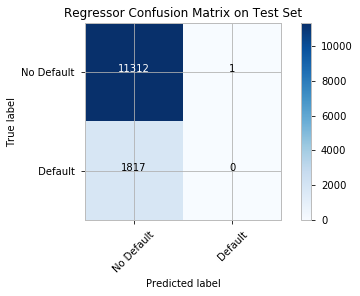

In [88]:
cm = confusion_matrix(y_test, reg.predict(X_test))
plt.figure()
plot_confusion_matrix(cm, classes=['No Default',' Default'],
                      normalize=False,
                      title='Regressor Confusion Matrix on Test Set')

Our regression was not able to discriminate between defaulting and non-defaulting applicants, and appears to be a "Naive" classifier in the sense that simply predicts the majority class. Let's try again, increasing the weight of the minority class:

In [89]:
balanced_reg = LogisticRegression(class_weight='balanced')
balanced_reg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

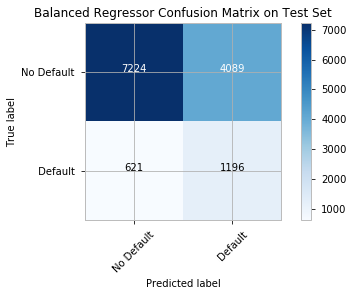

In [91]:
cm = confusion_matrix(y_test, balanced_reg.predict(X_test))
plt.figure()
plot_confusion_matrix(cm, classes=['No Default',' Default'],
                      normalize=False,
                      title='Balanced Regressor Confusion Matrix on Test Set')

Naturally, the recall of the defaulted has increased; most loans that Default are predicted as such. However, the precision is very low; most predictions of "Default" will be incorrect. At this point, the researcher must determine the relative costs of false positives and false negatives, and adjust a discriminative threshold accordingly. To help us understand this, we'll vary the threshold to see how well we do on the "Default" class.

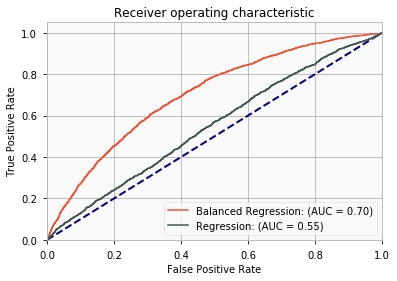

In [167]:
plot_roc_curve(y_test, X_test, {'Regression':reg, 
                                "Balanced Regression":balanced_reg})

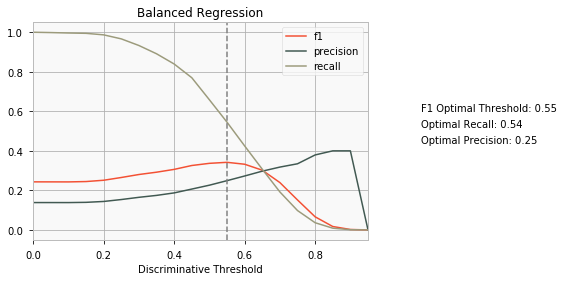

In [155]:
ax = plot_discriminative_thresholds(balanced_reg, y_test)
ax.set_title("Balanced Regression")

Unfortunately, the regression is unacceptable at all thresholds. 

### Train a Random Forest

In [255]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint
parameters = {"max_depth": [3, None],
              "max_features": randint(2, 21)}
rf = RandomizedSearchCV(RandomForestClassifier(n_estimators = 300, 
                                               class_weight='balanced'), 
                        parameters, 
                        n_jobs = 4)
rf.fit(X_train, y_train)

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params={}, iid=True, n_iter=10, n_jobs=4,
          param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f37b20c5190>, 'max_depth': [3, None]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring=None, verbose=0)

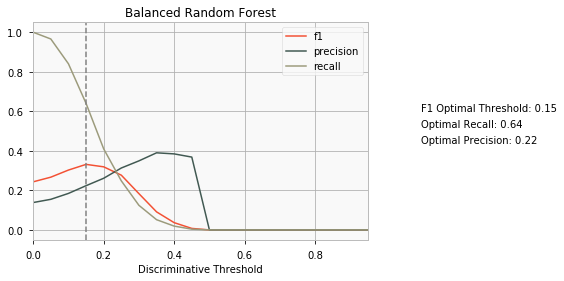

In [256]:
ax = plot_discriminative_thresholds(rf, y_test)
ax.set_title("Balanced Random Forest")

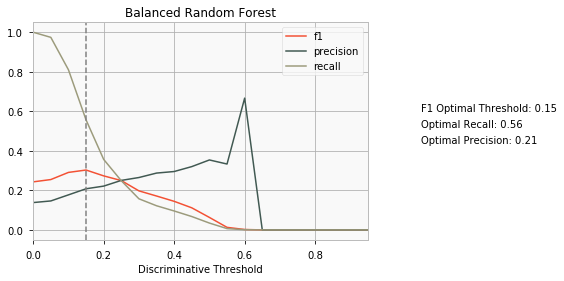

In [162]:
ax = plot_discriminative_thresholds(ensemble_soft, y_test)
ax.set_title("Balanced Random Forest")

### Train a feed forward NN

Were going to do some grid search over the number of layers.

In [243]:
def create_nn(layer_size):
    # create model
    model = Sequential()
    layer_size = 30
    model.add(Dense(X.shape[1], input_dim=X.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dense(layer_size, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(.1))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
    

    
class_weights = {0: y_train.mean(), 1: 1 - y_train.mean()}

class NNPipeline(Pipeline):
    def __init__(self, layer_size=10, n_epochs=None):
        if n_epochs is None:
            n_epochs = 10
        
        def nn_func():
            return create_nn(layer_size)
        
        nn_estimators = []
        nn_estimators.append(('standardize', StandardScaler()))
        nn_estimators.append(('mlp', KerasClassifier(build_fn=nn_func, 
                                                  epochs=n_epochs, 
                                                  batch_size=5, 
                                                  verbose=0,
                                                  class_weight = class_weights
                                                 )))        
        
        super(NNPipeline,self).__init__(nn_estimators)
        

In [246]:
from sklearn.model_selection import GridSearchCV
parameters = {'layer_size':[35, 45, 55, 65, 75]}
gsnn = GridSearchCV(NNPipeline(), parameters)
gsnn.fit(X_train, y_train)

In [205]:
from functools import partial

def create_nn(layer_size):
    # create model
    model = Sequential()
    layer_size = 30
    model.add(Dense(X.shape[1], input_dim=X.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dense(layer_size, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(.1))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

class_weights = {0: y_train.mean(), 1: 1 - y_train.mean()}

for i in [20, 25, 30, 35, 40]:
    def nn_func():
        return create_nn(i) #partial(create_nn, *(i, ))
    nn_estimators = []
    nn_estimators.append(('standardize', StandardScaler()))
    nn_estimators.append(('mlp', KerasClassifier(build_fn=nn_func, 
                                              epochs=10, 
                                              batch_size=5, 
                                              verbose=1,
                                              class_weight = class_weights
                                             )))
    
    nn = Pipeline(nn_estimators)
    nn.fit(X_train, y_train)
    
    preds = nn.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, preds)
    print "N layers: {0}, AUC: {1}".format(i, auc(fpr, tpr))

Epoch 1/10
26656/26656 [==============================] - 3s - loss: 0.1591 - acc: 0.6053     
Epoch 2/10
26656/26656 [==============================] - 3s - loss: 0.1559 - acc: 0.6135     
Epoch 3/10
26656/26656 [==============================] - 3s - loss: 0.1547 - acc: 0.6146     
Epoch 4/10
26656/26656 [==============================] - 3s - loss: 0.1534 - acc: 0.6322     
Epoch 5/10
26656/26656 [==============================] - 4s - loss: 0.1523 - acc: 0.6357     
Epoch 6/10
26656/26656 [==============================] - 4s - loss: 0.1510 - acc: 0.6487     
Epoch 7/10
26656/26656 [==============================] - 4s - loss: 0.1495 - acc: 0.6553     
Epoch 8/10
26656/26656 [==============================] - 4s - loss: 0.1482 - acc: 0.6662     
Epoch 9/10
26656/26656 [==============================] - 3s - loss: 0.1464 - acc: 0.6704     
Epoch 10/10
12025/13130 [==========================>...] - ETA: 0sN layers: 20, AUC: 0.685423196783
Epoch 1/10
26656/26656 [=====================

In [204]:
roc_curve?

In [179]:
roc_curve()

In [173]:
os.environ['KERAS_BACKEND'] = 'theano'
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras.callbacks import Callback

class Logger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        print "Epoch: %s, loss: %0.3f" %(epoch, logs.get('loss'))
        

def create_nn(layer_size):
    # create model
    model = Sequential()
    layer_size = 30
    model.add(Dense(X.shape[1], input_dim=X.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dense(layer_size, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(.1))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


class_weights = {0: y_train.mean(), 1: 1 - y_train.mean()}
callbacks = [Logger()]

nn_estimators = []
nn_estimators.append(('standardize', StandardScaler()))
nn_estimators.append(('mlp', KerasClassifier(build_fn=create_nn, 
                                          epochs=100, 
                                          batch_size=5, 
                                          verbose=0,
                                          callbacks = callbacks,
                                          class_weight = class_weights
                                         )))
nn = Pipeline(nn_estimators)
nn.fit(X_train, y_train)

Epoch: 0, loss: 0.160
Epoch: 1, loss: 0.156
Epoch: 2, loss: 0.155
Epoch: 3, loss: 0.154
Epoch: 4, loss: 0.152
Epoch: 5, loss: 0.151
Epoch: 6, loss: 0.149
Epoch: 7, loss: 0.147
Epoch: 8, loss: 0.146
Epoch: 9, loss: 0.144
Epoch: 10, loss: 0.142
Epoch: 11, loss: 0.140
Epoch: 12, loss: 0.138
Epoch: 13, loss: 0.137
Epoch: 14, loss: 0.134
Epoch: 15, loss: 0.133
Epoch: 16, loss: 0.130
Epoch: 17, loss: 0.129
Epoch: 18, loss: 0.126
Epoch: 19, loss: 0.124
Epoch: 20, loss: 0.122
Epoch: 21, loss: 0.120
Epoch: 22, loss: 0.119
Epoch: 23, loss: 0.117
Epoch: 24, loss: 0.116
Epoch: 25, loss: 0.114
Epoch: 26, loss: 0.113
Epoch: 27, loss: 0.111
Epoch: 28, loss: 0.111
Epoch: 29, loss: 0.109
Epoch: 30, loss: 0.108
Epoch: 31, loss: 0.106
Epoch: 32, loss: 0.106
Epoch: 33, loss: 0.105
Epoch: 34, loss: 0.104
Epoch: 35, loss: 0.103
Epoch: 36, loss: 0.102
Epoch: 37, loss: 0.100
Epoch: 38, loss: 0.099
Epoch: 39, loss: 0.100
Epoch: 40, loss: 0.097
Epoch: 41, loss: 0.096
Epoch: 42, loss: 0.097
Epoch: 43, loss: 0.09

Pipeline(steps=[('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('mlp', <keras.wrappers.scikit_learn.KerasClassifier object at 0x7f37b6037410>)])

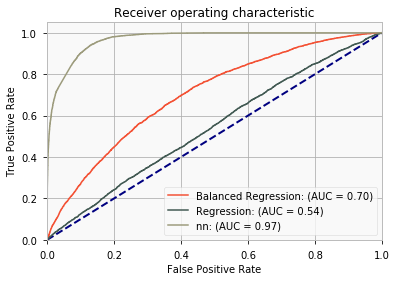

In [176]:
plot_roc_curve(y_train, X_train, {'Regression':reg, 
                                "Balanced Regression":balanced_reg,
                                'nn':nn})

In [36]:
from sklearn.ensemble import VotingClassifier


rf2 = RandomForestClassifier(class_weight='balanced', n_estimators=40)
reg2 = LogisticRegression()
nn_estimators2 = []
nn_estimators2.append(('standardize', StandardScaler()))
nn_estimators2.append(('mlp', KerasClassifier(build_fn=create_nn, 
                                          epochs=100, 
                                          batch_size=5, 
                                          verbose=10,
                                         )))
nn2 = Pipeline(nn_estimators2)


ensemble_soft = VotingClassifier([('rf',rf2), 
                                  ('regression', reg2), 
                                  ('neural_network',nn2)], 
                                 voting='soft')
ensemble_soft.fit(X_train, y_train)

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100
Epoch 77/100
Epoch 78

VotingClassifier(estimators=[('rf', RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0...with_std=True)), ('mlp', <keras.wrappers.scikit_learn.KerasClassifier object at 0x7f37b8b76450>)]))],
         n_jobs=1, voting='soft', weights=None)

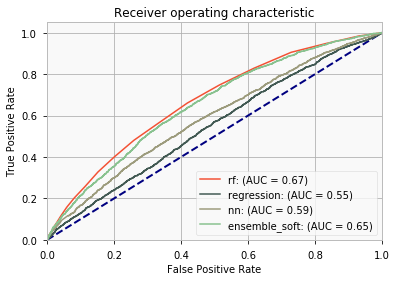

In [165]:
models = {'regression':reg,
          'nn':pipeline,
          'ensemble_soft':ensemble_soft,
          'rf':rf,}
ax = plot_roc_curve(y_test, X_test, models)

In [30]:
from sklearn.metrics import classification_report
reports = []
for model_key in models:
    
    test_preds = models[model_key].predict(X_test)
    report = classifaction_report_csv(classification_report(y_test, test_preds))
    report['model'] = model_key
    report = report.set_index(['model','class'])
    reports.append(report)

reports = pd.concat(reports)
reports[['precision','recall']]

precision  recall
model      class                   
rf         0           0.86    0.99
           1           0.33    0.03
regression 0           0.86    1.00
           1           0.00    0.00
nn         0           0.87    0.93
           1           0.22    0.13

### Given the recall on default class, NN is our pick

Lets use skater to explore our model

In [17]:
from skater import Interpretation
from skater.model import InMemoryModel

model_nn = InMemoryModel(pipeline.predict_proba, target_names=['Paid off',' Default'], examples=X_train[:5])

interpreter = Interpretation(X_train, feature_names=domain_columns)


### Feature importance (top 20)

In [18]:
importances = interpreter.feature_importance.feature_importance(model_nn)

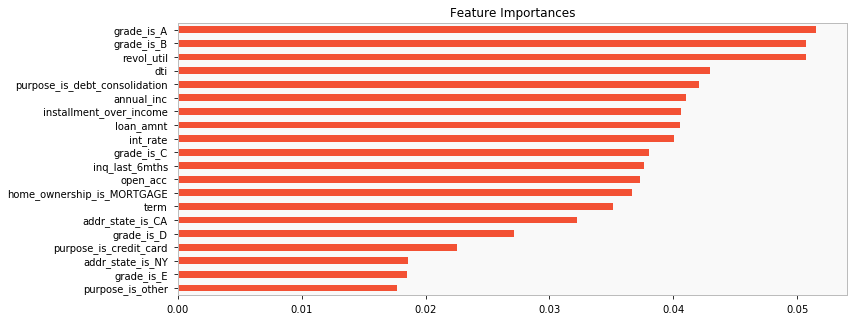

In [19]:
ax = importances.iloc[-20:].plot(kind='barh', figsize = (12, 5))
ax.grid()
title = ax.set_title('Feature Importances')

### Evaluate the relationship between top features and default risk:

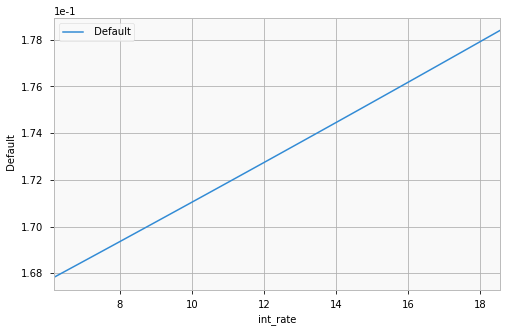

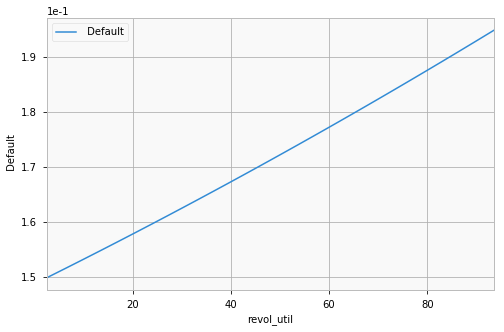

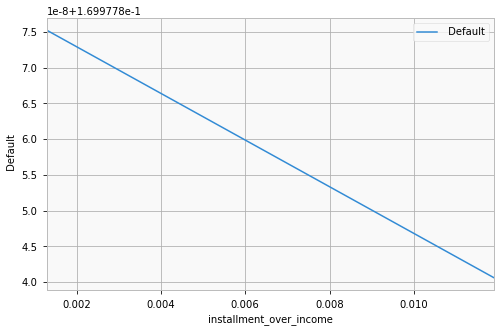

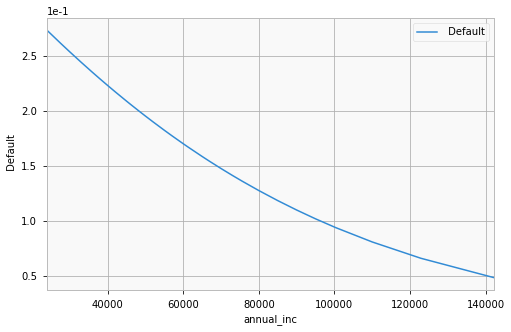

In [15]:
plots = interpreter.partial_dependence.plot_partial_dependence(['int_rate',
                                                        'revol_util',
                                                        'installment_over_income',
                                                        'annual_inc'], 
                                                       model_nn, 
                                                       n_samples=500,
                                                       figsize=(8, 5))

### Most of the key relationships are linear

In [234]:
%matplotlib notebook

[[<matplotlib.figure.Figure at 0x7fe93824b1d0>,

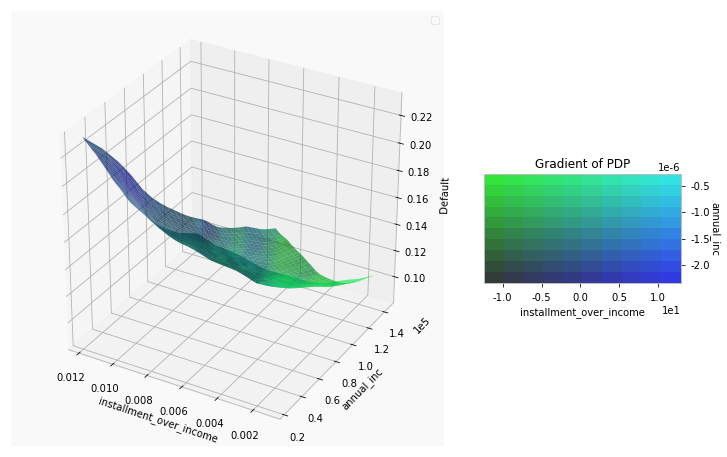

In [21]:
interpreter.partial_dependence.plot_partial_dependence([('installment_over_income','annual_inc')], 
                                                       model_nn, 
                                                       n_samples=500,
                                                       figsize = (12, 8))

[[<matplotlib.figure.Figure at 0x7fe90d8b3d90>,

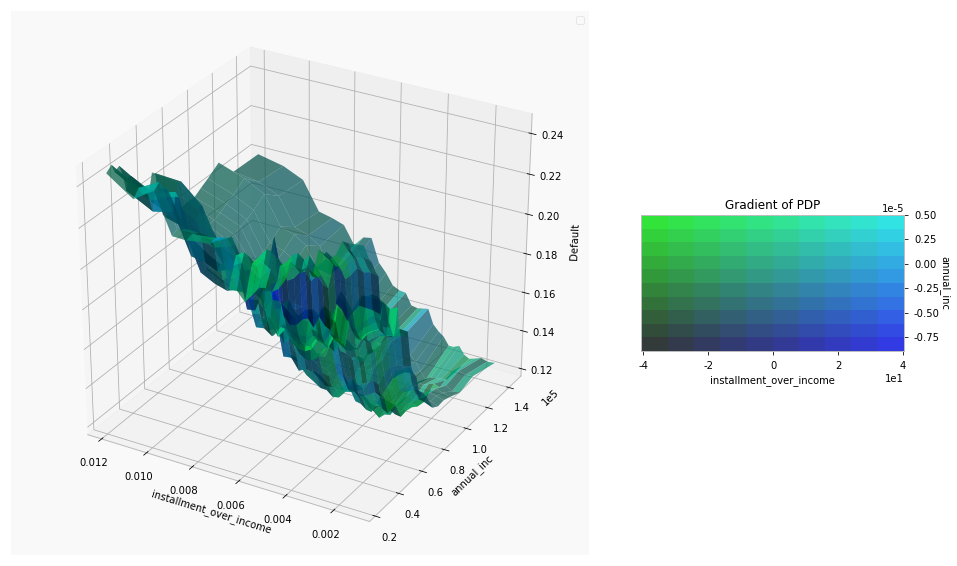

In [22]:
model_rf = InMemoryModel(rf.predict_proba, target_names=['Paid off',' Default'], examples=X_train[:5])
interpreter.partial_dependence.plot_partial_dependence([('installment_over_income','annual_inc')], 
                                                       model_rf, 
                                                       n_samples=500)

In [164]:
test_preds = rf.predict(X_test)
report = classifaction_report_csv(classification_report(y_test, test_preds))
report['set'] = 'test'

train_preds = rf.predict(X_train)
report2 = classifaction_report_csv(classification_report(y_train, train_preds))
report2['set'] = 'train'


report = pd.concat((report, report2), ignore_index=True)
report.style.set_table_styles(styles)


,class,f1_score,precision,recall,support,set
0,0,0.93,0.86,1,11313,test
1,1,0.02,0.38,0.01,1817,test
2,0,1,1,1,22803,train
3,1,0.99,1,0.99,3853,train
